In [1]:
import json
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib import rc
import random

In [2]:
# matplotlib 한글 폰트 깨짐 문제 해결
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fontprop = fm.FontProperties(fname=font_path)

In [8]:
# 경로 설정

data_path = '/workspace/Data_All/'

img_path = data_path + 'image/'                     # /workspace/Data_All/image/
json_path = data_path + 'label/'                    # /workspace/Data_All/label/
segment_path = data_path + 'segmentation/'          # /workspace/Data_All/segmentation/

anger_img_path = img_path + 'anger'                 # /workspace/Data_ALL/image/anger/

In [ ]:
# 라벨 정보 json 파일 (train, val, test 파일 통합)
# train_anger.json + val_anger.json + test_anger.json -> json_anger

# json 파일 각각 불러오기
with open (json_path + "train_anger.json", "r", encoding='euc-kr') as f:
    json_anger_train = json.load(f)
with open (json_path + "val_anger.json", "r", encoding='euc-kr') as f:
    json_anger_val = json.load(f)
with open (json_path + "test_anger.json", "r", encoding='euc-kr') as f:
    json_anger_test = json.load(f)

# 하나의 파일로 통합
json_anger = []
if isinstance(json_anger_train, list):
    json_anger.extend(json_anger_train)
if isinstance(json_anger_val, list):
    json_anger.extend(json_anger_val)
if isinstance(json_anger_test, list):
    json_anger.extend(json_anger_test)

In [12]:
len(json_anger)     # 1500(train) + 300(val) + 300(test) = 2100

2100

In [17]:
# 이미지와 json 파일 내 이름이 일치하는지 확인

IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count

image_count = count_images_in_folder(anger_img_path)
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_anger)}")
print()

# 폴더 내 이미지 파일 이름 수집
def get_image_files_in_folder(folder_path):
    image_files = set()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_files.add(file)
    return image_files

# JSON 파일 내 이미지 파일 이름 수집
def get_image_files_in_json(json_file):
    json_filenames = {entry["filename"] for entry in json_file}
    return json_filenames

# 비교 수행
image_files_in_folder = get_image_files_in_folder(anger_img_path)
image_files_in_json = get_image_files_in_json(json_anger)

# 누락된 파일 찾기
missing_in_json = image_files_in_folder - image_files_in_json
missing_in_folder = image_files_in_json - image_files_in_folder

# 결과 출력 
print(f"JSON 파일에 없는 폴더 내 이미지 파일: {missing_in_json}")
print(f"폴더에 없는 JSON 파일의 이미지 파일: {missing_in_folder}")

폴더 내 이미지 파일 개수: 2100
json 파일 길이 : 2100

JSON 파일에 없는 폴더 내 이미지 파일: set()
폴더에 없는 JSON 파일의 이미지 파일: set()


In [13]:
json_anger[0]

{'filename': '6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63ec1162f5f6bfc6e481l.jpg',
 'gender': '남',
 'age': 30,
 'isProf': '일반인',
 'faceExp_uploader': '분노',
 'bg_uploader': '교통/이동수단(엘리베이터 포함)',
 'annot_A': {'boxes': {'maxX': 2073.2546049999996,
   'maxY': 1486.204442,
   'minX': 1338.2201049999999,
   'minY': 539.5066419999999},
  'faceExp': '분노',
  'bg': '교통/이동수단(엘리베이터 포함)'},
 'annot_B': {'boxes': {'maxX': 2074.6636049999997,
   'maxY': 1490.044442,
   'minX': 1341.270105,
   'minY': 528.132642},
  'faceExp': '분노',
  'bg': '교통/이동수단(엘리베이터 포함)'},
 'annot_C': {'boxes': {'maxX': 2072.188605,
   'maxY': 1487.918442,
   'minX': 1340.0851049999999,
   'minY': 525.650642},
  'faceExp': '분노',
  'bg': '교통/이동수단(엘리베이터 포함)'}}

In [14]:
# Json 파일 -> DataFrame 변환
# df_anger

# 데이터 변환 함수 정의
def process_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # annot_A, annot_B, annot_C 데이터 추가
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            row = {
                **base_info,
                'annot': annot_key,
                'faceExp': annot.get('faceExp'),
                'bg': annot.get('bg'),
                'minX': annot.get('boxes', {}).get('minX'),
                'minY': annot.get('boxes', {}).get('minY'),
                'maxX': annot.get('boxes', {}).get('maxX'),
                'maxY': annot.get('boxes', {}).get('maxY'),
            }
            processed_data.append(row)
    return pd.DataFrame(processed_data)

# 데이터프레임 생성
df_anger = process_data(json_anger)

In [15]:
df_anger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          6300 non-null   object 
 1   gender            6300 non-null   object 
 2   age               6300 non-null   int64  
 3   isProf            6300 non-null   object 
 4   faceExp_uploader  6300 non-null   object 
 5   bg_uploader       6300 non-null   object 
 6   annot             6300 non-null   object 
 7   faceExp           6300 non-null   object 
 8   bg                6300 non-null   object 
 9   minX              6300 non-null   float64
 10  minY              6300 non-null   float64
 11  maxX              6300 non-null   float64
 12  maxY              6300 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 640.0+ KB


In [16]:
df_anger

filename gender  age isProf  \
0     6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63...      남   30    일반인   
1     6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63...      남   30    일반인   
2     6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63...      남   30    일반인   
3     65rsfe402042f34319e10128c1ab9614e2f967690a64a0...      남   40    전문인   
4     65rsfe402042f34319e10128c1ab9614e2f967690a64a0...      남   40    전문인   
...                                                 ...    ...  ...    ...   
6295  ukcud12e88bddb1b23ae550da52e62d360f1050368d390...      여   20    일반인   
6296  ukcud12e88bddb1b23ae550da52e62d360f1050368d390...      여   20    일반인   
6297  i0hqb9b9a850e9a46de055a7a080a140c0ab15644fa411...      여   30    전문인   
6298  i0hqb9b9a850e9a46de055a7a080a140c0ab15644fa411...      여   30    전문인   
6299  i0hqb9b9a850e9a46de055a7a080a140c0ab15644fa411...      여   30    전문인   

     faceExp_uploader        bg_uploader    annot faceExp                 bg  \
0                  분노  교통/이동수단(엘리베이터 포함)  annot_A      분노  교통/이동수단(엘리베이터 포함)   
1                  분노  교통/이동수단(엘리베이터 포함)  annot_B      분노  교통/이동수단(엘리베이터 포함)   
2                  분노  교통/이동수단(엘리베이터 포함)  annot_C      분노  교통/이동수단(엘리베이터 포함)   
3                  분노          문화재 및 유적지  annot_A      분노            행사/사무공간   
4                  분노          문화재 및 유적지  annot_B      분노         공공시설/종교/의료   
...               ...                ...      ...     ...                ...   
6295               분노         상업시설/점포/시장  annot_B      중립         상업시설/점포/시장   
6296               분노         상업시설/점포/시장  annot_C      분노         상업시설/점포/시장   
6297               분노          문화재 및 유적지  annot_A      분노            실외 자연환경   
6298               분노          문화재 및 유적지  annot_B      분노         공공시설/종교/의료   
6299               분노          문화재 및 유적지  annot_C      분노          문화재 및 유적지   

             minX        minY         maxX         maxY  
0     1338.220105  539.506642  2073.254605  1486.204442  
1     1341.270105  528.132642  2074.663605  1490.044442  
2     1340.085105  525.650642  2072.188605  1487.918442  
3     1812.222817  711.278453  2889.526926  2306.348256  
4     1816.913391  688.002830  2875.110464  2311.339041  
...           ...         ...          ...          ...  
6295  1021.574286  259.669725  2111.335754  1468.623853  
6296  1040.552167  212.809348  2040.766452  1551.357319  
6297   684.099600  296.248870  1534.433300  1466.875400  
6298   745.749082  335.657119  1523.622842  1478.306175  
6299   717.115447  314.693036  1541.903746  1499.941579  

[6300 rows x 13 columns]

##### 표정 데이터 확인
- faceExp_uploader (image) 와 faceExp (annot) 차이 확인
- 표정 정보가 다른 이미지들 어떻게 처리할지

In [18]:
df_anger['faceExp_uploader'].value_counts()


faceExp_uploader
분노    6300
Name: count, dtype: int64

In [19]:
df_anger['faceExp'].value_counts()

faceExp
분노    4473
불안     625
슬픔     292
중립     287
상처     286
당황     286
기쁨      51
Name: count, dtype: int64

In [20]:
# faceExp가 분노가 아닌 데이터 추출
def process_non_anger_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # Process each annotation and filter for non-anger faceExp
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            face_exp = annot.get('faceExp')
            if face_exp != "분노":  # Only include non-anger faceExp
                row = {
                    **base_info,
                    'annot': annot_key,
                    'faceExp': face_exp,
                    'bg': annot.get('bg'),
                    'minX': annot.get('boxes', {}).get('minX'),
                    'minY': annot.get('boxes', {}).get('minY'),
                    'maxX': annot.get('boxes', {}).get('maxX'),
                    'maxY': annot.get('boxes', {}).get('maxY'),
                }
                processed_data.append(row)
    return pd.DataFrame(processed_data)

df_not_anger = process_non_anger_data(json_anger)

In [21]:
df_not_anger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          1827 non-null   object 
 1   gender            1827 non-null   object 
 2   age               1827 non-null   int64  
 3   isProf            1827 non-null   object 
 4   faceExp_uploader  1827 non-null   object 
 5   bg_uploader       1827 non-null   object 
 6   annot             1827 non-null   object 
 7   faceExp           1827 non-null   object 
 8   bg                1827 non-null   object 
 9   minX              1827 non-null   float64
 10  minY              1827 non-null   float64
 11  maxX              1827 non-null   float64
 12  maxY              1827 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 185.7+ KB


In [22]:
df_not_anger

filename gender  age isProf  \
0     b1cbe34734870cc11c33334e02bea93ac3a3b061caab62...      여   20    전문인   
1     b1cbe34734870cc11c33334e02bea93ac3a3b061caab62...      여   20    전문인   
2     b1cbe34734870cc11c33334e02bea93ac3a3b061caab62...      여   20    전문인   
3     3hww73b70615461a7336d0383b53582f8bf804f6e0f30d...      여   30    일반인   
4     s5p48256122b20ab3b5025653432de00948c526e391549...      여   20    일반인   
...                                                 ...    ...  ...    ...   
1822  px5scb4a23e3a7cbbd9bb1e1315bf33328225dc58c87b7...      여   20    일반인   
1823  ud069a37a29c25fa251250a4b898653f6925583139d801...      남   40    전문인   
1824  i23ied1bcd80626bc574c69a81c4d1d0c981c6af5845a0...      남   20    전문인   
1825  ukcud12e88bddb1b23ae550da52e62d360f1050368d390...      여   20    일반인   
1826  ukcud12e88bddb1b23ae550da52e62d360f1050368d390...      여   20    일반인   

     faceExp_uploader bg_uploader    annot faceExp          bg         minX  \
0                  분노     오락/공연시설  annot_A      상처       도심 환경  1092.901126   
1                  분노     오락/공연시설  annot_B      불안       도심 환경  1011.849151   
2                  분노     오락/공연시설  annot_C      슬픔   숙박 및 거주공간  1061.689000   
3                  분노  상업시설/점포/시장  annot_A      기쁨  상업시설/점포/시장   614.351500   
4                  분노  상업시설/점포/시장  annot_C      중립       도심 환경   740.189200   
...               ...         ...      ...     ...         ...          ...   
1822               분노  상업시설/점포/시장  annot_C      슬픔   숙박 및 거주공간   518.154050   
1823               분노     오락/공연시설  annot_A      상처     오락/공연시설  1139.691300   
1824               분노  상업시설/점포/시장  annot_B      불안  공공시설/종교/의료  1324.465471   
1825               분노  상업시설/점포/시장  annot_A      슬픔  상업시설/점포/시장  1064.143093   
1826               분노  상업시설/점포/시장  annot_B      중립  상업시설/점포/시장  1021.574286   

            minY         maxX         maxY  
0     565.437117  1950.380119  1564.586938  
1     395.670259  2036.463513  1572.633082  
2     429.089300  1953.119000  1569.929200  
3     295.559080  1402.888900  1383.816300  
4     800.589200  1548.365400  1893.815200  
...          ...          ...          ...  
1822  164.299090   922.723270   782.504827  
1823  574.710700  1950.154900  1686.310500  
1824  558.907685  2201.730129  1889.240194  
1825  157.504587  2077.280708  1519.706422  
1826  259.669725  2111.335754  1468.623853  

[1827 rows x 13 columns]

In [23]:
df_not_anger['faceExp'].value_counts()

faceExp
불안    625
슬픔    292
중립    287
상처    286
당황    286
기쁨     51
Name: count, dtype: int64

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


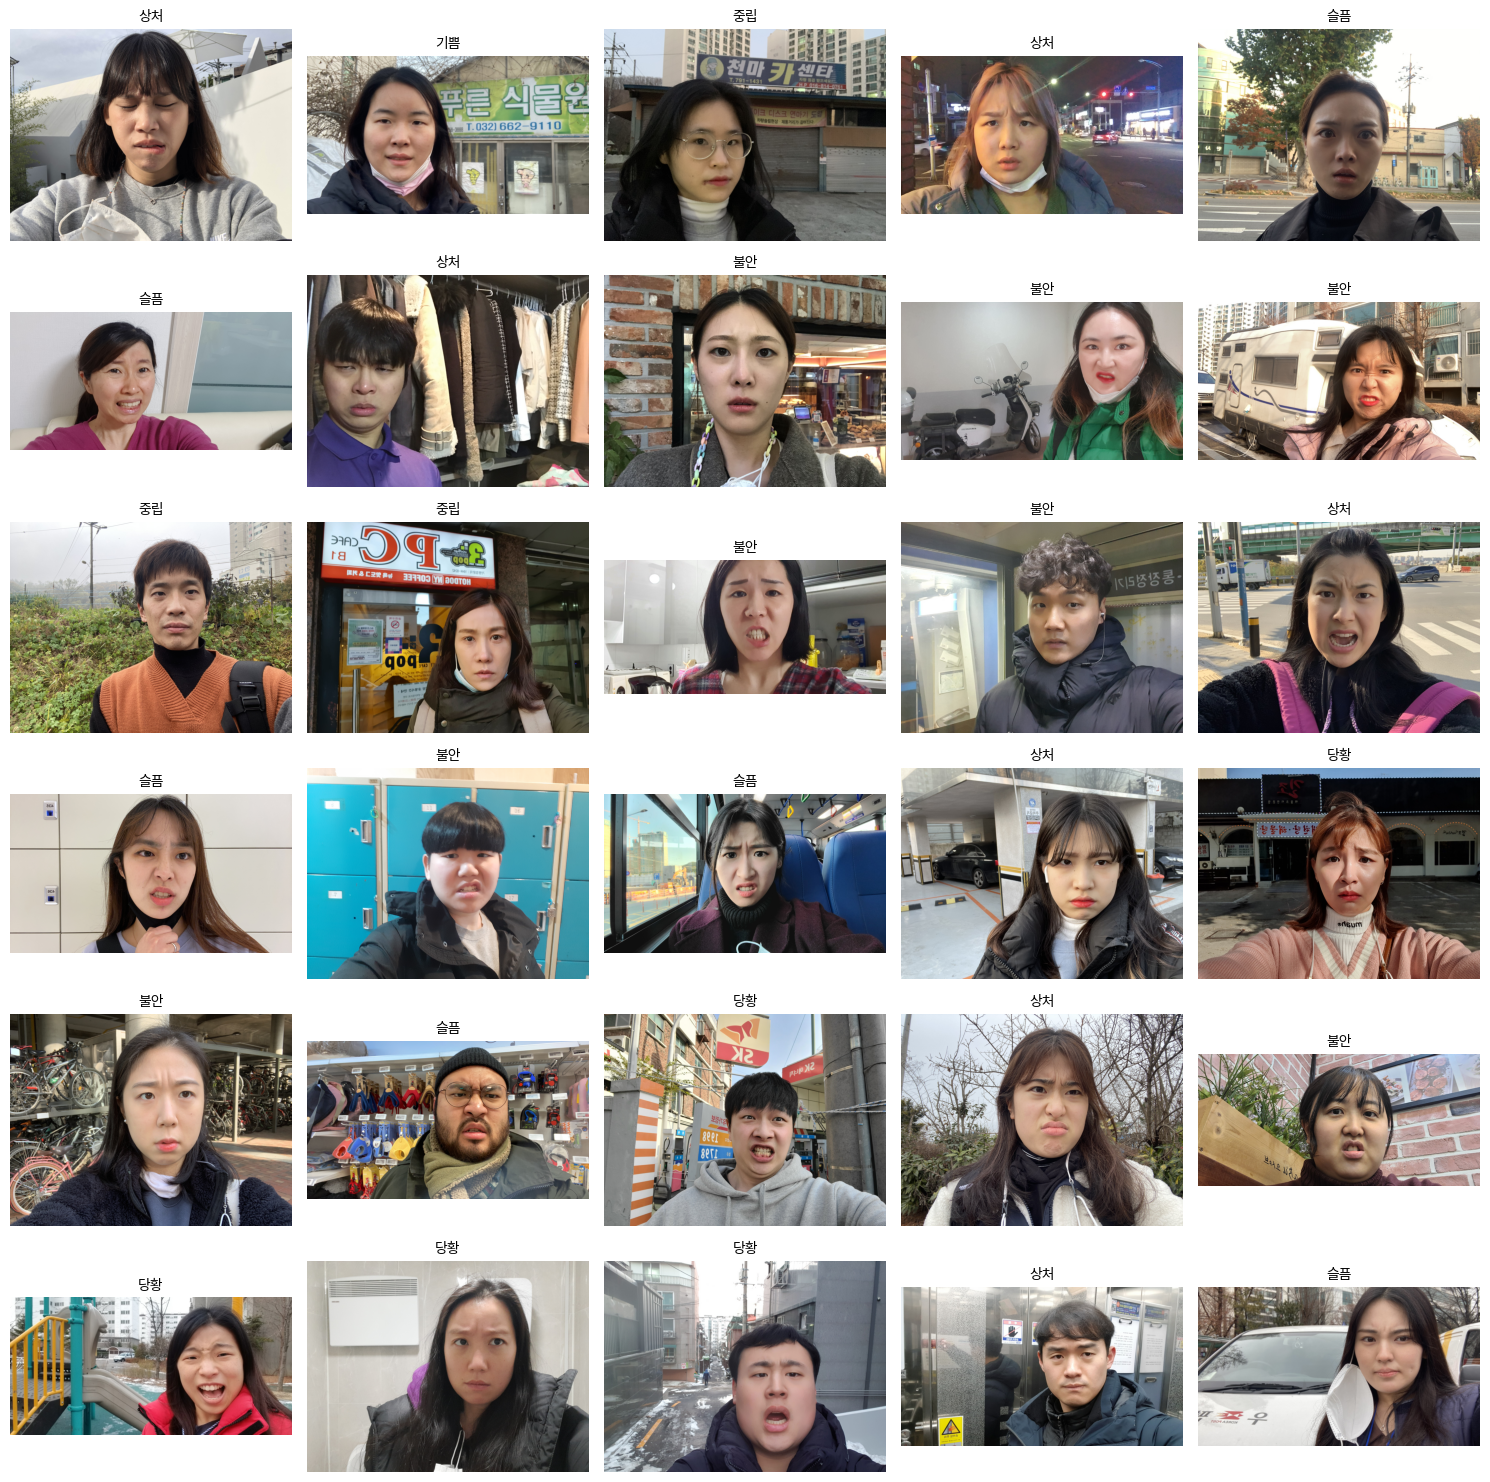

In [26]:
# 감정 정보가 다른 이미지 시각화
unique_filenames = df_not_anger['filename'].unique()

plt.figure(figsize=(15, 15))

for i, filename in enumerate(unique_filenames):
    if i >= 30:  # Show only the first 30 images for this example
        break
    image_path = os.path.join(anger_img_path, filename)
    if os.path.exists(image_path):  # Ensure the file exists
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(6, 5, i + 1)
        plt.imshow(image)
        faceExp = df_not_anger[df_not_anger['filename'] == filename]['faceExp'].iloc[0]
        plt.title(faceExp, fontproperties=fontprop)
        plt.axis('off')

plt.tight_layout()
plt.show()

##### 연령, 성별, 전문인 column 분포 확인

In [29]:
# 연령 분포 확인
df_anger['age'].value_counts(), df_anger['age'].value_counts(normalize=True)

(age
 20    3147
 30    2235
 40     708
 50     129
 10      69
 60      12
 Name: count, dtype: int64,
 age
 20    0.499524
 30    0.354762
 40    0.112381
 50    0.020476
 10    0.010952
 60    0.001905
 Name: proportion, dtype: float64)

In [30]:
# 성별 분포 확인
df_anger['gender'].value_counts(), df_anger['gender'].value_counts(normalize=True)

(gender
 여    3393
 남    2907
 Name: count, dtype: int64,
 gender
 여    0.538571
 남    0.461429
 Name: proportion, dtype: float64)

In [31]:
# 전문인 여부
df_anger['isProf'].value_counts(), df_anger['isProf'].value_counts(normalize=True)

(isProf
 일반인    3165
 전문인    3135
 Name: count, dtype: int64,
 isProf
 일반인    0.502381
 전문인    0.497619
 Name: proportion, dtype: float64)

##### 배경 정보 확인
- bg_uploader와 bg 차이 확인
- 배경 정보가 다른 이미지들 어떻게 처리할지

In [32]:
# 배경 정보
df_anger['bg_uploader'].value_counts(), df_anger['bg'].value_counts()

(bg_uploader
 숙박 및 거주공간            1119
 상업시설/점포/시장           1098
 공공시설/종교/의료시설          786
 도심 환경                 762
 실외 자연환경               642
 교통/이동수단(엘리베이터 포함)     606
 오락/공연시설               366
 문화재 및 유적지             342
 스포츠 관람 및 레저시설         306
 행사/사무공간               273
 Name: count, dtype: int64,
 bg
 상업시설/점포/시장           1169
 숙박 및 거주공간            1138
 공공시설/종교/의료           1009
 도심 환경                 704
 실외 자연환경               690
 교통/이동수단(엘리베이터 포함)     490
 행사/사무공간               369
 오락/공연시설               317
 스포츠 관람 및 레저시설         199
 문화재 및 유적지             170
 공공시설/종교/의료시설           45
 Name: count, dtype: int64)

##### 박스 좌표 정보 확인
- 한 이미지 내 박스 좌표가 유사한지 시각화 및 좌표 수치 확인

In [48]:
# 박스 A,B,C의 좌표 차이가 일정 수치 이상인 데이터 검출

# 차이 확인 함수
def is_significant_difference(boxA, boxB, boxC, threshold):
    def box_difference(box1, box2):
        return sum(abs(box1[key] - box2[key]) for key in box1)
    
    diff_AB = box_difference(boxA, boxB)
    diff_BC = box_difference(boxB, boxC)
    diff_CA = box_difference(boxC, boxA)
    
    return max(diff_AB, diff_BC, diff_CA) > threshold

# 유사하지 않은 데이터를 저장할 리스트
outlier_filenames = []

# 박스 좌표 분석
thershold = 500

for entry in json_anger:
    annot_A = entry['annot_A']['boxes']
    annot_B = entry['annot_B']['boxes']
    annot_C = entry['annot_C']['boxes']
    
    if is_significant_difference(annot_A, annot_B, annot_C, thershold):
        outlier_filenames.append(entry['filename'])

# 결과 출력
print(f"outlier 파일 수:{len(outlier_filenames)}")

# outlier 데이터 추출 (json)
def extract_outliers(data, outlier_filenames):
    return [entry for entry in data if entry['filename'] in outlier_filenames]

outlier_json_anger = extract_outliers(json_anger, outlier_filenames)

outlier 파일 수:8


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


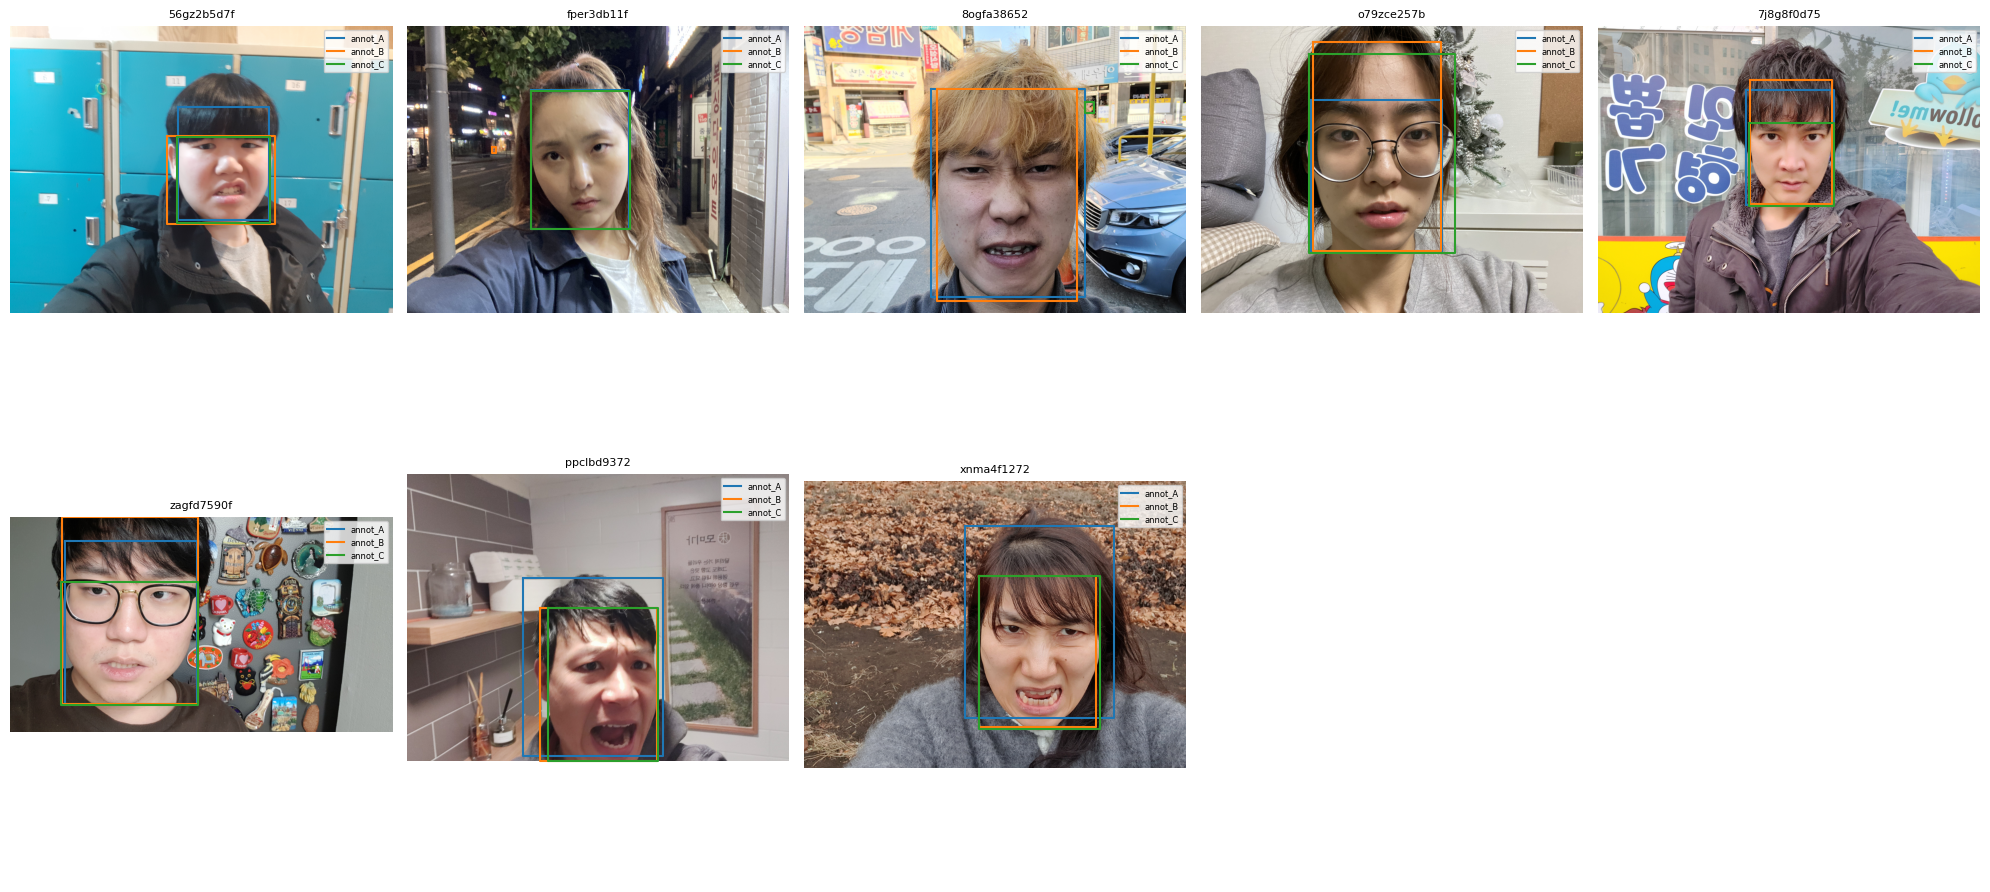

In [53]:
# outlier 시각화

# 이미지,박스 시각화 함수 정의
def visualize_boxes(data, image_dir):
    # data = data[:10]  # 30개 이미지만 시각화
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()

    for idx, item in enumerate(data):
        filename = item['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            continue

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image) 
        axes[idx].axis('off')

        # Plot boxes from annotations
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            if annot_key in item:
                box = item[annot_key]['boxes']
                x = [box['minX'], box['maxX'], box['maxX'], box['minX'], box['minX']]
                y = [box['minY'], box['minY'], box['maxY'], box['maxY'], box['minY']]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)
       
    # Hide unused subplots
    for i in range(len(data), 10):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
visualize_boxes(outlier_json_anger, anger_img_path)

In [56]:
# outlier 데이터 좌표 출력

def format_boxes(box):
    return {key: round(value, 2) for key, value in box.items()}

def print_outlier_coordinates(outlier_data):
    for i, entry in enumerate(outlier_data):
        print(f"Outlier {i+1}:")
        print(f"Filename: {entry['filename']}")
        print(f"  annot_A: {format_boxes(entry['annot_A']['boxes'])}")
        print(f"  annot_B: {format_boxes(entry['annot_B']['boxes'])}")
        print(f"  annot_C: {format_boxes(entry['annot_C']['boxes'])}")
        print("-" * 50)

print_outlier_coordinates(outlier_json_anger)

Outlier 1:
Filename: 56gz2b5d7f85e5224f8c4b8ca22b822cc74684a2623cccac4ecaefa1e3a5aj5op.jpg
  annot_A: {'maxX': 3122.28, 'maxY': 2335.06, 'minX': 2028.43, 'minY': 976.63}
  annot_B: {'maxX': 3196.46, 'maxY': 2390.17, 'minX': 1887.59, 'minY': 1330.05}
  annot_C: {'maxX': 3137.42, 'maxY': 2376.91, 'minX': 2018.38, 'minY': 1336.84}
--------------------------------------------------
Outlier 2:
Filename: fper3db11fef98f236117e11df9f5ad4a93e1c9bf2172b1fa9bf41e47f2b17siz.jpg
  annot_A: {'maxX': 1795.42, 'maxY': 1639.41, 'minX': 1004.0, 'minY': 519.08}
  annot_B: {'maxX': 715.29, 'maxY': 1025.97, 'minX': 682.77, 'minY': 978.44}
  annot_C: {'maxX': 1801.49, 'maxY': 1639.29, 'minX': 1000.98, 'minY': 523.62}
--------------------------------------------------
Outlier 3:
Filename: 8ogfa38652ea8c683e6e77ce6a635a586dec07484a7a8428ed5ba78e3d22cjubb.jpg
  annot_A: {'maxX': 2165.36, 'maxY': 2084.8, 'minX': 975.41, 'minY': 484.28}
  annot_B: {'maxX': 2106.81, 'maxY': 2117.52, 'minX': 1020.82, 'minY': 484.